Data gathering

analysis of 2 or 3 different kind of algorithms we will use: kNN, maxent, logistic regression, deep learning, and support vector machines.

each method has a different pre processing and strengths and interpretatio


kNN- tokenizing, all lower case, removing common words, lematisize, tagging words as preposition/conjunction/etc,  TF IDF

Do we remove stop words, or not?
Do we stem or lemmatize our text data, or leave the words as is?
Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
Do we stick with English words only or do we allow for other languages?
Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?

In [349]:
#!pip install Levenshtein
#!pip install pandas
#!pip install nltk
#!pip install Levenshtein
#!pip install textblob
#!pip install scikit-learn

In [350]:
#imports

import numpy as np
from textblob import TextBlob
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import re
import os
import nltk
import Levenshtein
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline

In [351]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [352]:
import shutil

def zip_folder(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

# Example usage
#folder_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT/Raw_Songs_DataBase'  # Replace with the path to your folder
#zip_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT'  # Replace with the desired path and name for the zip file

#zip_folder(folder_path, zip_path)

In [353]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [354]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 50

In [355]:
#get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
artists = random.sample(artists_all, NUMBER_OF_ARTISTS)
artists = sorted(artists)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    #path_to_rid = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

In [356]:
#print(artists)

In [357]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()


Now let us get some data about the songs

Number of songs : 4184
Number of artists : 50
Average number of songs per artist : 83


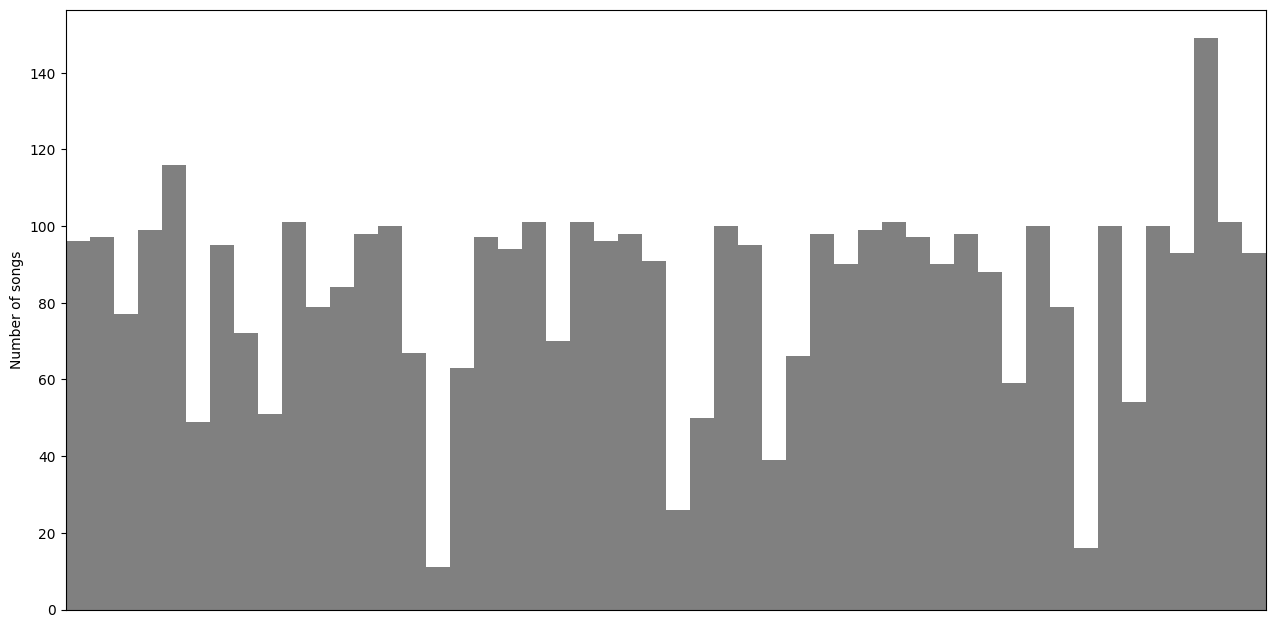

In [358]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

keys = songs_per_artist.keys()
values = songs_per_artist.values()

fig = plt.figure(figsize=(12, 6))  # Set the figure size
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust margins

bar_lefts = range(len(keys))
bar_heights = values

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')  # Customize the appearance

plt.ylabel('Number of songs')

plt.xticks([])  # Remove x-axis tick labels
plt.xlabel('')  # Remove x-axis legend

plt.xlim(-0.5, len(keys) - 0.5)  # Adjust x-axis limits

plt.show()

In [359]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #get number of lines
    nb_lines = text.count("\n")
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists
    text = [word for sentence in text for word in sentence]
    
    #remove all expressions in between brackets and empty words
    text = [word for word in text if len(word) != 0 and word[0]!= "["]
    
    #stemmatization
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    
    nb_words = len(text)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

Let's vizualize the data

In [360]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [361]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist
0,"[i'v, got, a, newfound, fangl, fandango, tango...",14,83,\nI've got a new-found fangled fandango tango ...,angle,0
1,"[you'v, been, away, for, such, a, long, long, ...",15,140,"\nYou've been away for such a long, long time\...",50 pieces,0
2,"[overprescrib, under, the, mister, we, had, su...",48,260,\nOverprescribed\nUnder the mister\nWe had sur...,a nervous tic motion of the head to the left,0
3,"[sinc, i, first, saw, him, i, think, myself, b...",21,164,"\nSince I first saw him, I think myself blind....",a woman's life and love,0
4,"[now, if, you, think, i'm, wast, your, time, a...",46,258,\nNow if you think I'm wasting your time again...,action adventure,0


In [362]:
def plot_box_graph(features):
    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [arts_dict_op[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])

        xtick_labels = [arts_dict_op[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        
        plt.show()
        
def plot_bar_graph(feature):
    
    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

    plt.bar(np.arange(len(to_plot)), to_plot) 
    xtick_labels = [arts_dict_op[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)  
    plt.title(feature)

    plt.show()

In [363]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [364]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:SENSATION:TASTE,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:AFFECTION,...,RID_PRIMARY:SENSATION:GENERAL-SENSATION,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:VOYAGE,RID_PRIMARY:SENSATION:TOUCH,RID_PRIMARY:NEED:SEX,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:REGRESSIVE:COGNITION:UNKNOWN,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[i'v, got, a, newfound, fangl, fandango, tango...",14,83,\nI've got a new-found fangled fandango tango ...,angle,0,0.045455,0.034091,0.034091,0.022727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,35.000000,15.000000
1,"[you'v, been, away, for, such, a, long, long, ...",15,140,"\nYou've been away for such a long, long time\...",50 pieces,0,0.013699,0.000000,0.020548,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.217391,30.434783,4.347826
2,"[overprescrib, under, the, mister, we, had, su...",48,260,\nOverprescribed\nUnder the mister\nWe had sur...,a nervous tic motion of the head to the left,0,0.000000,0.000000,0.036364,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.000000,23.333333,11.666667
3,"[sinc, i, first, saw, him, i, think, myself, b...",21,164,"\nSince I first saw him, I think myself blind....",a woman's life and love,0,0.018182,0.006061,0.006061,0.012121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.909091,15.909091,18.181818
4,"[now, if, you, think, i'm, wast, your, time, a...",46,258,\nNow if you think I'm wasting your time again...,action adventure,0,0.010417,0.000000,0.006944,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.985915,53.521127,15.492958


In [365]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 52 duplicates


In [366]:
def similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / max_length * 100
    return similarity

# Create a mask to identify the rows to drop
mask = np.zeros(len(df), dtype=bool)

for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # Filter rows with the same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    
    # Calculate similarity scores between song1 and duplicate rows
    similarity_scores = duplicate_rows["Raw_Lyrics"].apply(lambda x: similarity(song1, x))
    
    # Identify rows with similarity scores above 80
    similar_rows = duplicate_rows[similarity_scores > 80]
    
    df.drop(similar_rows.index, inplace=True)

# Drop the marked rows using the mask
#df.drop(df.index[mask], inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 22 covers


In [367]:
df = df[df['Nb_Words'] >= 50]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s5 = df.shape[0]

print(f'Dropped {s4 - s5} intros and outros')

Dropped 98 songs that were too short
Dropped 6 intros and outros


In [368]:
# Compute the count of instances for each artist
artist_counts = df['Artist'].value_counts()

# Identify artists with counts less than 50
artists_to_drop = artist_counts[artist_counts < 50].index

# Create a boolean mask indicating rows to be dropped
mask = df['Artist'].isin(artists_to_drop)

# Filter and drop the corresponding rows from the DataFrame
df.drop(df[mask].index, inplace=True)

l1 = len(artists)
# Remove the artists from the artists array
new_artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
dropped_artists = [art for art in artists if arts_dict[art] in artists_to_drop]
for art in dropped_artists:
    del arts_dict_op[arts_dict[art]]
    del arts_dict[art]
    
l2 = len(new_artists)


s6 = df.shape[0]
print(f'Dropped {l1 - l2} artists that had too few songs : -{s5 - s6} songs')

Dropped 6 artists that had too few songs : -179 songs


In [369]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Waylon Jennings (148 songs)
Artist with the least songs: Japanese Breakfast (50 songs)


In [370]:
# Identify artists with a total number of songs greater than 130
artists_above_threshold = artist_counts[artist_counts > 130].index

# Iterate over each artist
for artist in artists_above_threshold:
    # Get the indices of songs by the current artist
    artist_indices = df[df['Artist'] == artist].index
    
    # Calculate the number of songs to be dropped
    songs_to_drop = len(artist_indices) - 130
    
    # Randomly select and drop songs until count reaches 130
    songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
    df.drop(artist_indices.difference(songs_to_keep), inplace=True)

s7 = df.shape[0]
print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

Dropped 18 songs from undersampling too represented artists


In [371]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(arts_dict)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(arts_dict))}')

AFTER CLEANING

Number of songs : 3809
Number of artists : 44
Average number of songs per artist : 86


In [372]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

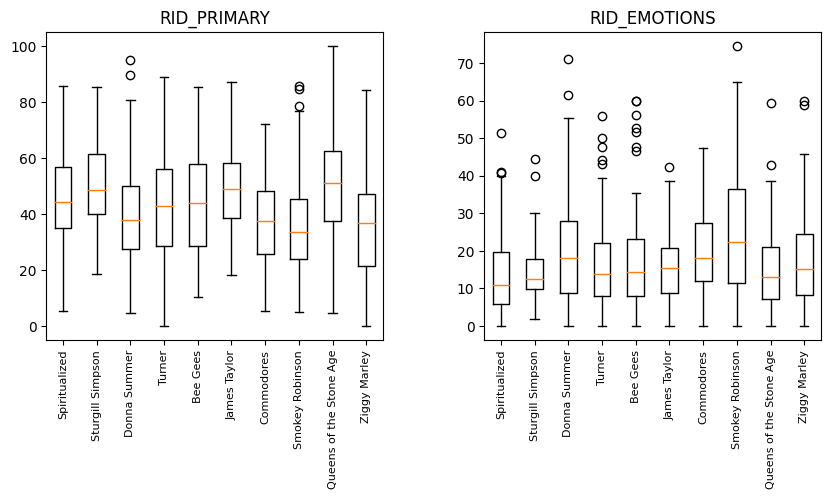

In [373]:
plot_box_graph(["RID_PRIMARY", "RID_EMOTIONS"])

In [374]:
df_rid = df.filter(regex=r'^RID')
df_rid

,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:SENSATION:TASTE,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:AFFECTION,RID_SECONDARY:TEMPORAL:REFERENCES,RID_EMOTIONS:AGGRESSION,RID_PRIMARY:SENSATION:SOFT,RID_SECONDARY:ABSTRACTION,RID_PRIMARY:ICARIAN:IMAGERY:HEIGHT,RID_PRIMARY:NEED:ANALITY,...,RID_PRIMARY:SENSATION:GENERAL-SENSATION,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:VOYAGE,RID_PRIMARY:SENSATION:TOUCH,RID_PRIMARY:NEED:SEX,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:REGRESSIVE:COGNITION:UNKNOWN,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,0.045455,0.034091,0.034091,0.022727,0.022727,0.011364,0.011364,0.011364,0.011364,0.011364,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,50.000000,35.000000,15.000000
1,0.013699,0.000000,0.020548,0.000000,0.034247,0.013699,0.000000,0.027397,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,65.217391,30.434783,4.347826
2,0.000000,0.000000,0.036364,0.000000,0.014545,0.000000,0.000000,0.018182,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,65.000000,23.333333,11.666667
3,0.018182,0.006061,0.006061,0.012121,0.012121,0.012121,0.006061,0.012121,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,65.909091,15.909091,18.181818
4,0.010417,0.000000,0.006944,0.000000,0.072917,0.000000,0.000000,0.024306,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,30.985915,53.521127,15.492958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.005882,0.000000,0.005882,0.023529,0.023529,0.005882,0.000000,0.047059,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,38.709677,45.161290,16.129032
4180,0.000000,0.000000,0.000000,0.004762,0.023810,0.052381,0.000000,0.038095,0.004762,0.000000,...,0.000000,0.000000,0.0,0.004762,0.0,0.0,0.000000,61.971831,19.718310,18.309859
4181,0.131313,0.013468,0.016835,0.020202,0.016835,0.013468,0.000000,0.016835,0.020202,0.013468,...,0.000000,0.006734,0.0,0.006734,0.0,0.0,0.000000,43.518519,46.296296,10.185185
4182,0.030588,0.000000,0.000000,0.009412,0.021176,0.023529,0.000000,0.035294,0.000000,0.000000,...,0.002353,0.000000,0.0,0.000000,0.0,0.0,0.002353,35.922330,48.543689,15.533981


In [375]:
# Instantiate PCA with the number of components set to the total number of features
pca = PCA(n_components=len(df_rid.columns))

# Fit PCA on the standardized features
pca.fit(df_rid)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the variance ratios in descending order
sorted_variance_ratio = sorted(explained_variance_ratio, reverse=True)

# Get the indices of the top 10 features with the most variance
top_10_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Keep only the top 10 features in the DataFrame
df_top_10 = df_rid.iloc[:, top_10_indices]
df_top_10.columns

Index(['RID_SECONDARY:INSTRUMENTAL:BEHAVIOR', 'RID_PRIMARY:SENSATION:TASTE',
       'RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM', 'RID_EMOTIONS:AFFECTION',
       'RID_SECONDARY:TEMPORAL:REFERENCES', 'RID_EMOTIONS:AGGRESSION',
       'RID_PRIMARY:SENSATION:SOFT', 'RID_SECONDARY:ABSTRACTION',
       'RID_PRIMARY:ICARIAN:IMAGERY:HEIGHT', 'RID_PRIMARY:NEED:ANALITY'],
      dtype='object')

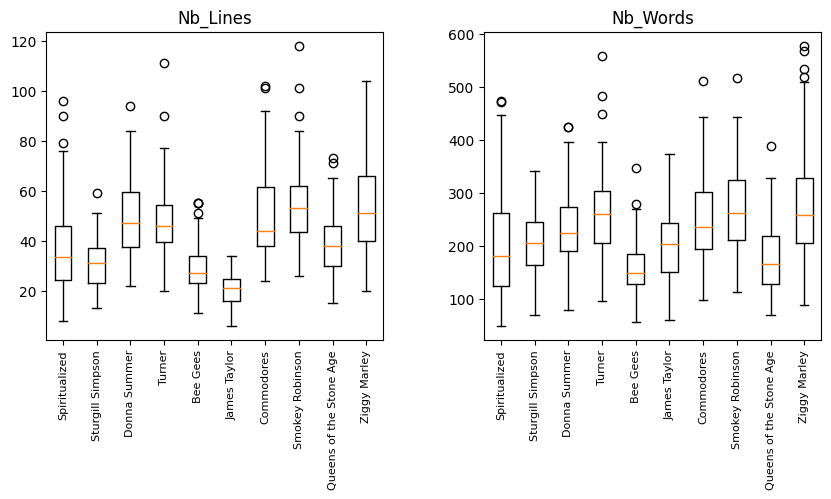

In [376]:
plot_box_graph(["Nb_Lines", "Nb_Words"])

In [377]:
df["Nb_Words_Per_Line"] = df["Nb_Words"]/df["Nb_Lines"]

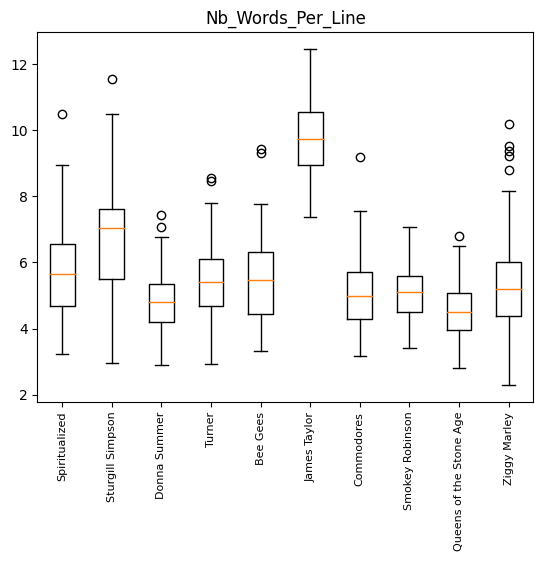

In [378]:
plot_box_graph(["Nb_Words_Per_Line"])

We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [379]:
songs = df["Lyrics"].to_list()
nb_words = df["Nb_Words"].to_list()

#unique word means appears only once in the song
TTR = []
for song, l in zip(songs, nb_words):
    dic = {word: 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word] += 1
        if dic[word] > 1: #if it appeared more than once, add it
            non_unique_words.add(word)
    nb_unique_words = l - len(non_unique_words)
    ttr = nb_unique_words / l
    TTR.append(ttr)
    
df['TTR'] = TTR

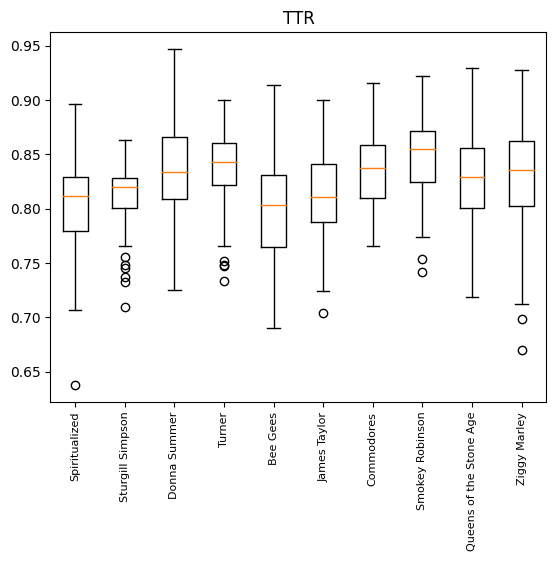

In [380]:
plot_box_graph(["TTR"])

In [381]:
supertags_dict = {
    'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V', #verbs
    'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N', #nouns
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', #adverbs
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ', #adjectives
    'DT': 'DET', 'PDT': 'DET', 'WDT': 'DET', #determinents
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON'} #pronouns

supertags = ['N', 'V', 'ADV', 'ADJ', 'DET', 'PRON']
chunk_tags = ['GPE', 'PERSON', 'ORGANIZATION', 'LOCATION', 'FACILITY', 'GSP']

#'GPE': 'Geopolitical Entity: Refers to countries, cities, states, or regions.',
#'PERSON': 'Person: Refers to individuals or groups of people.',
#'ORGANIZATION': 'Organization: Refers to named entities representing companies, institutions, or groups.',
#'LOCATION': 'Location: Refers to specific places or locations.',
#'FACILITY': 'Facility: Refers to buildings, structures, or other physical facilities.',
#'GSP': 'General Single Purpose: Refers to a general chunk tag with a single-purpose label.'

def split_sentences(text):

    text = re.sub(r'\([^()]*\)', ' ', text)
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('  ', ' ')
    sentences = re.split(r'(?:[.!?])|\n\n', text)
    sentences = [s.strip() for s in sentences if len(s)!=0]
    return sentences

In [382]:
def pos_chunk(text):
    # Tokenize into sentences and words
    sentences = split_sentences(text)
    words = [nltk.word_tokenize(sent) for sent in sentences]
    
    # POS tagging
    pos_tags = [nltk.pos_tag(sent) for sent in words]
    
    # Chunking
    chunked_sentences = [nltk.ne_chunk(pos_tag_sent) for pos_tag_sent in pos_tags]

    # Calculate POS tag distribution
    pos_tag_distribution = {suptag: 0 for suptag in supertags}
    for sent in pos_tags:
        pos_tag_distribution.update({supertags_dict[tag]: pos_tag_distribution.get(supertags_dict[tag], 0) + 1
                                     for _, tag in sent if tag in supertags_dict})

    # Calculate chunk tag distribution
    chunk_tag_distribution = {chunk_tag: 0 for chunk_tag in chunk_tags}
    for sent in chunked_sentences:
        chunk_tag_distribution.update({chunk.label(): chunk_tag_distribution.get(chunk.label(), 0) + 1
                                       for chunk in sent if hasattr(chunk, 'label') and chunk.label() in chunk_tags})

    return pos_tag_distribution, chunk_tag_distribution


In [383]:
raw_songs = df["Raw_Lyrics"].to_list()
#df = df.drop("Raw_Lyrics", axis = 1)
nb_words = df["Nb_Words"].to_list()

In [384]:

POS = {'POS_'+key : [] for key in supertags}

CHUNK = {'CHUNK_'+key : [] for key in chunk_tags}

for raw, l in zip(raw_songs, nb_words):
    pos, chunk = pos_chunk(raw)
    for key in pos.keys():
        POS['POS_'+key].append(pos[key] / l)
        
    for key in chunk.keys():
        CHUNK['CHUNK_'+key].append(chunk[key] / l)

In [385]:
df = df.assign(**POS)
df = df.assign(**CHUNK)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:SENSATION:TASTE,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:AFFECTION,...,POS_ADV,POS_ADJ,POS_DET,POS_PRON,CHUNK_GPE,CHUNK_PERSON,CHUNK_ORGANIZATION,CHUNK_LOCATION,CHUNK_FACILITY,CHUNK_GSP
0,"[i'v, got, a, newfound, fangl, fandango, tango...",14,83,\nI've got a new-found fangled fandango tango ...,angle,0,0.045455,0.034091,0.034091,0.022727,...,0.024096,0.048193,0.048193,0.048193,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,"[you'v, been, away, for, such, a, long, long, ...",15,140,"\nYou've been away for such a long, long time\...",50 pieces,0,0.013699,0.000000,0.020548,0.000000,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.000000,0.0,0.0,0.0
2,"[overprescrib, under, the, mister, we, had, su...",48,260,\nOverprescribed\nUnder the mister\nWe had sur...,a nervous tic motion of the head to the left,0,0.000000,0.000000,0.036364,0.000000,...,0.019231,0.026923,0.030769,0.030769,0.007692,0.000000,0.007692,0.0,0.0,0.0
3,"[sinc, i, first, saw, him, i, think, myself, b...",21,164,"\nSince I first saw him, I think myself blind....",a woman's life and love,0,0.018182,0.006061,0.006061,0.012121,...,0.018293,0.012195,0.012195,0.024390,0.006098,0.006098,0.000000,0.0,0.0,0.0
4,"[now, if, you, think, i'm, wast, your, time, a...",46,258,\nNow if you think I'm wasting your time again...,action adventure,0,0.010417,0.000000,0.006944,0.000000,...,0.031008,0.023256,0.023256,0.031008,0.011628,0.000000,0.011628,0.0,0.0,0.0


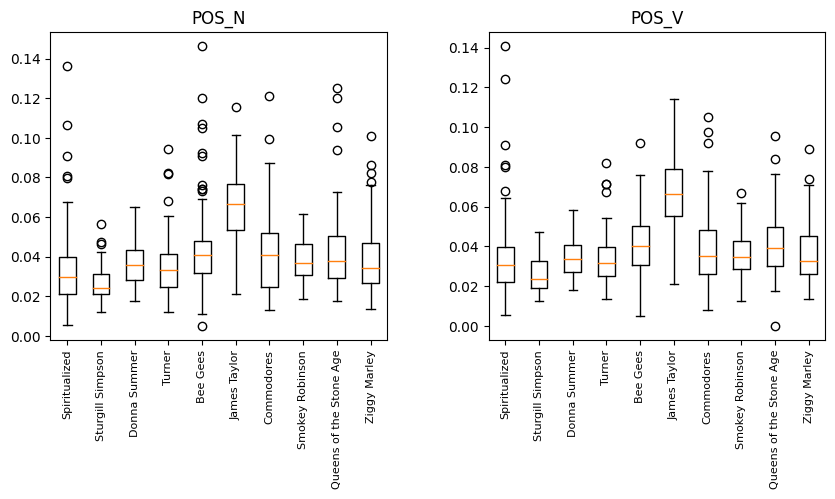

In [386]:
plot_box_graph(["POS_N", "POS_V"])

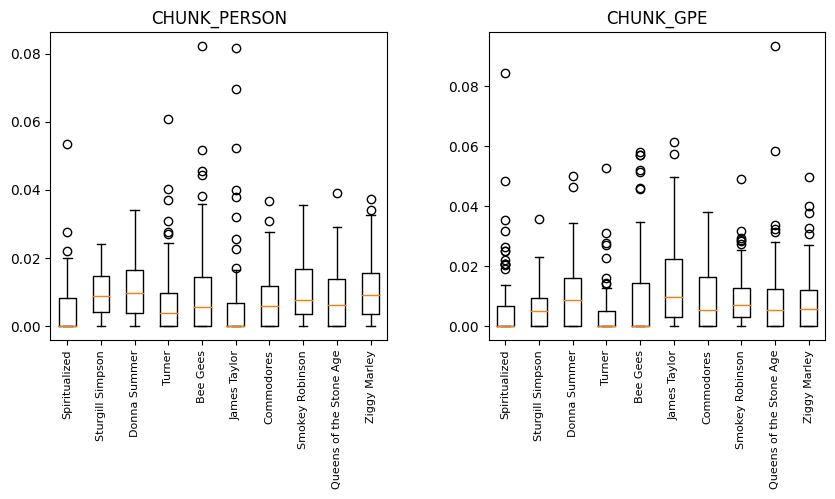

In [387]:
plot_box_graph(["CHUNK_PERSON", "CHUNK_GPE"])

Now we analyze prononces. We count the frequencies of 1st, 2nd, 3rd person pronons and the ratio of 1st person to 2d person to detect dialogue and interpersonal relations.

In [388]:
path_to_dicts = os.path.join(os.getcwd(), "Dictionaries")

path = os.path.join(path_to_dicts, "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(path_to_dicts, "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

songs = df["Lyrics"].to_list()

for song in songs:

    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

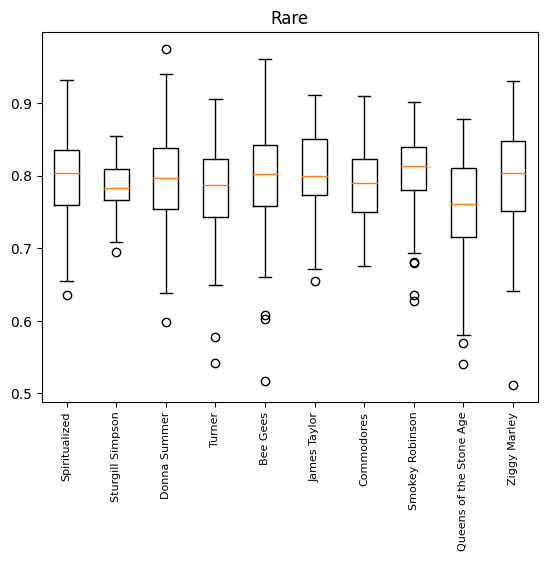

In [389]:
plot_box_graph(["Rare"])

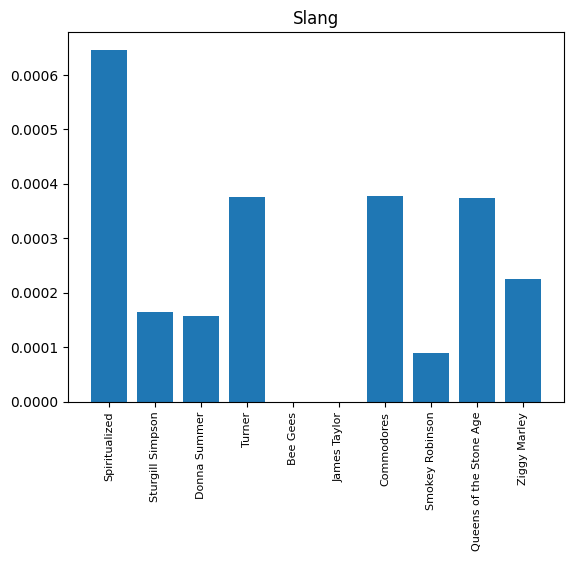

In [390]:
plot_bar_graph("Slang")

In [391]:
first_pers = []
second_pers = []
third_pers = []

for song in songs:
    first_pers_count = 0
    second_pers_count = 0
    third_pers_count = 0

    for word in song:
        if word in  {"i", "we"}:
            first_pers_count += 1
        if word == "you":
            second_pers_count += 1
        if word in  {"he", "she", "they"}:
            third_pers_count += 1
    
    song_len = len(song)
    first_pers.append(first_pers_count/song_len)
    second_pers.append(second_pers_count/song_len)
    third_pers.append(third_pers_count/song_len)
    
df['FP_Freq'] = first_pers
df['SP_Freq'] = second_pers
df['TP_Freq'] = third_pers

df["SR"] = df['FP_Freq']/(1 + df['SP_Freq'] + df['TP_Freq'])

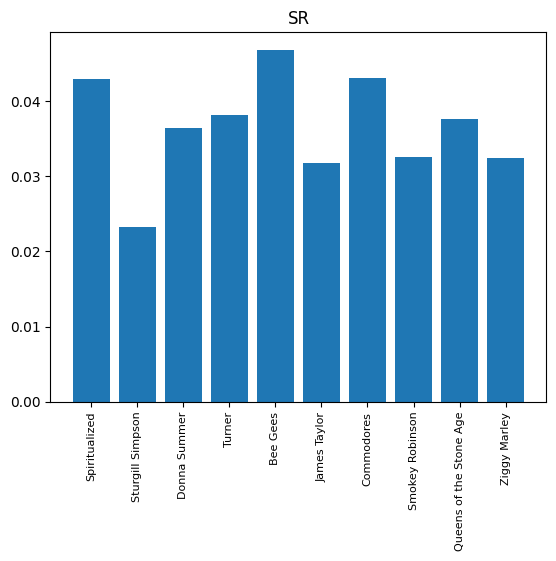

In [392]:
plot_bar_graph("SR")

Now we check whether or not the title appears in the song.

In [393]:
ttls = df["Title"].to_list()

title_in_song = []

raw_songs = [s.lower() for s in raw_songs]


for song, title, art in zip(raw_songs, ttls, df["Artist"].to_list()):
    pattern = re.escape(title)  # Escape special characters in the title
    if re.search(pattern, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)


df['Title_In_Song'] = title_in_song
                

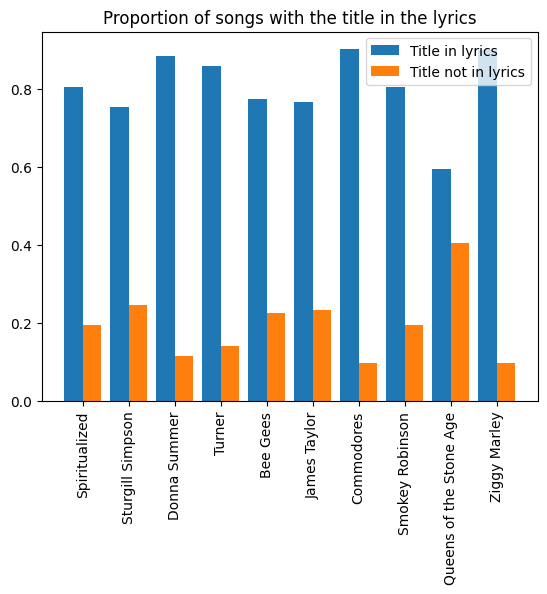

In [394]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [arts_dict_op[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics')
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics')

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

In [395]:
sub = []
pol = []
for song in raw_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub

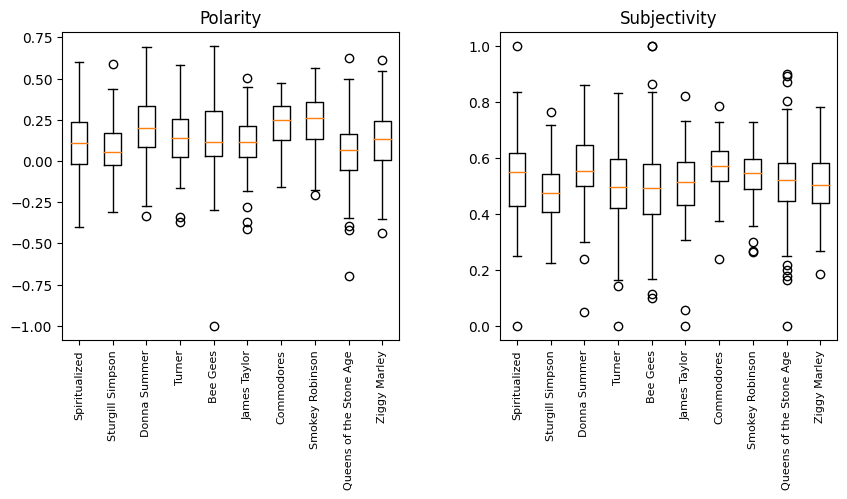

In [396]:
plot_box_graph(["Polarity", "Subjectivity"])

In [400]:
documents = []
for i in range(len(arts_dict_op)):
    d = df.loc[df['Artist'] == i, 'Lyrics'].tolist()
    d = [word for song in d for word in song]
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : np.arange(len(arts_dict_op))})

df_docs.head()

,All_Lyrics,Artist
0,i'v got a newfound fangl fandango tango angl a...,0
1,abraham took isaac' hand and led him to the lo...,1
2,i got some demon on me they been feed on me wh...,2
3,one year two year time goe by peopl laugh and ...,3
4,if i ain't got noth i got you if i ain't got s...,4


At this point we need to seperate train and test sets.

In [403]:
songs = df["Lyrics"].to_list()
string_songs = [' '.join(s) for s in songs]

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(string_songs)
#stem_count_vector = cv.fit_transform(documents)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(stem_count_vector)

df_word_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_word_weights.sort_values('weight').head()

,word,weight
14869,the,1.063944
15101,to,1.115620
753,and,1.117685
16828,you,1.119753
7682,it,1.251427


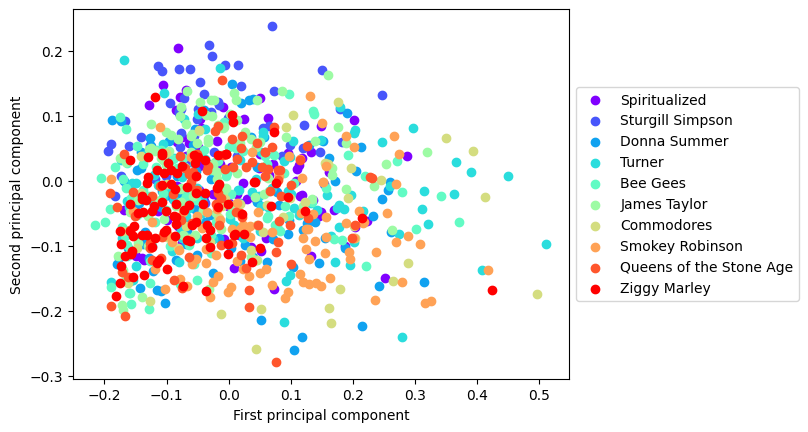

In [404]:
y_filtered = np.array(df["Artist"].to_list())

tfidf_transformer = TfidfTransformer()
tfidf_vector = tfidf_transformer.fit_transform(stem_count_vector).toarray()

pca = PCA(n_components=2).fit(tfidf_vector)
data2D = pca.transform(tfidf_vector)

artist_labels = [arts_dict_op[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors
for label, art, color in zip(sample, artist_labels, colors):
    mask = (y_filtered == label)
    scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

In [405]:
df_word_weights.sort_values('weight', ascending=False).head()

,word,weight
8456,leonardo,8.552237
9303,microag,8.552237
9288,mia,8.552237
9291,mica,8.552237
9292,micah,8.552237


In [406]:
tf_idf_vector = tfidf_transformer.transform(stem_count_vector)
tf_idf_matrix = tf_idf_vector.todense()
df_tfidf = pd.DataFrame(tf_idf_matrix, columns=cv.get_feature_names_out())
df_tfidf['Artist'] = df['Artist']
df_tfidf.head()

,00,000,0001,03,04,05,06,07,08,09,...,zoomzoom,zoot,zordon,zuckerberg,zuleyka,zuli,zulu,zumba,zwei,Artist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [407]:
valid_columns = df_tfidf.iloc[:, :-1].select_dtypes(include=np.number)
# Calculate the sum of each row
sum_array = np.array(valid_columns.sum(axis=1))

# Add the sum_array as a new column in the DataFrame
df["TF_IDF_Score"] = sum_array

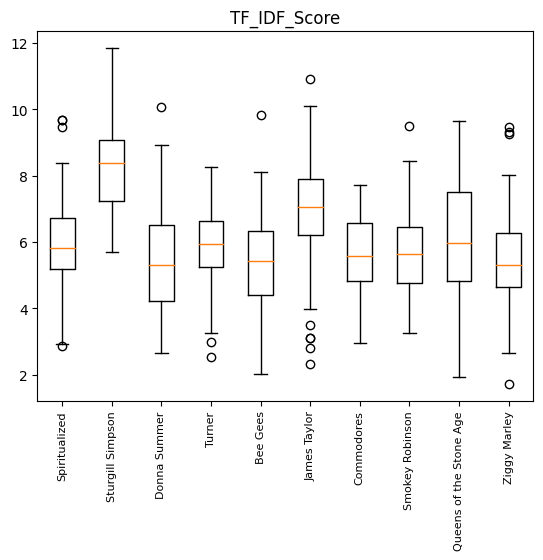

In [408]:
plot_box_graph(["TF_IDF_Score"])

We want a dataframe with the top 500 best words

In [409]:
# Select the columns that satisfy the condition
selected_columns = [column for column in df_tfidf.columns if 3 < df_tfidf[column].astype(bool).sum()]

df_filtered_weights = df_word_weights[df_word_weights["word"].isin(selected_columns)]
df_filtered_weights = df_filtered_weights.sort_values('weight', ascending=False)
df_filtered_weights.head()

,word,weight
5114,evermor,7.635947
11413,precis,7.635947
9618,morphin,7.635947
14487,surgeon,7.635947
11464,pretendin,7.635947


In [410]:
# Create a new DataFrame with the selected columns
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in selected_columns], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,10,100,1000,11,12,13,15,16,17,187,...,yup,zero,ziggi,zion,zip,zombi,zone,zoo,zoom,Artist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
old_columns = df_word_weights.shape[0]
new_columns = df_filtered_weights.shape[0]

print(f'Discarded {old_columns - new_columns} words')

Discarded 16984 words


In [411]:
to_keep = df_filtered_weights.iloc[:1000]["word"].tolist()

In [412]:
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in to_keep], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,evermor,precis,morphin,surgeon,pretendin,preserv,superstit,superman,european,euro,...,monopoli,mode,evict,rehears,harp,rejoic,stale,suburban,substanc,submiss
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116822,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


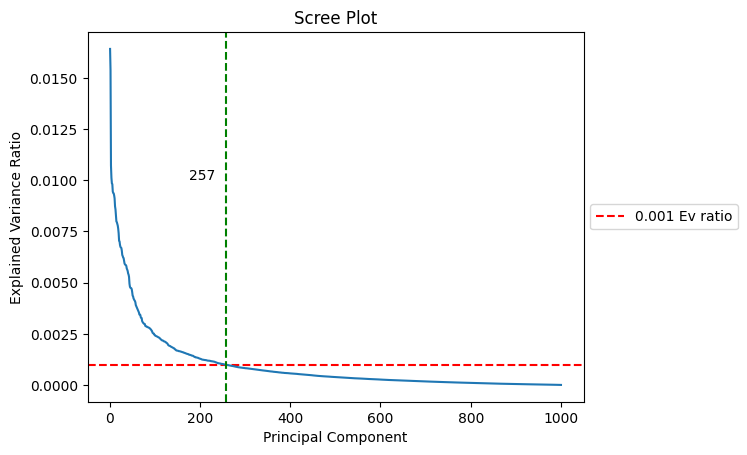

In [413]:
# Perform PCA
pca = PCA()
pca.fit(df_tfidf_reduced)
df_transformed = pca.transform(df_tfidf_reduced)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.axhline(y=0.001, color='r', linestyle='--', label='0.001 Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='', linestyle='-')

# Find the index of intersection
intersection_index = -1
for i in range(len(explained_variance_ratio)):
    if explained_variance_ratio[i] <= 0.001:
        intersection_index = i
        break

# Add a vertical line at the intersection point
plt.axvline(x=intersection_index + 1, color='g', linestyle='--')
plt.text(intersection_index - 50, 0.01, f'{intersection_index + 1}', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.show()


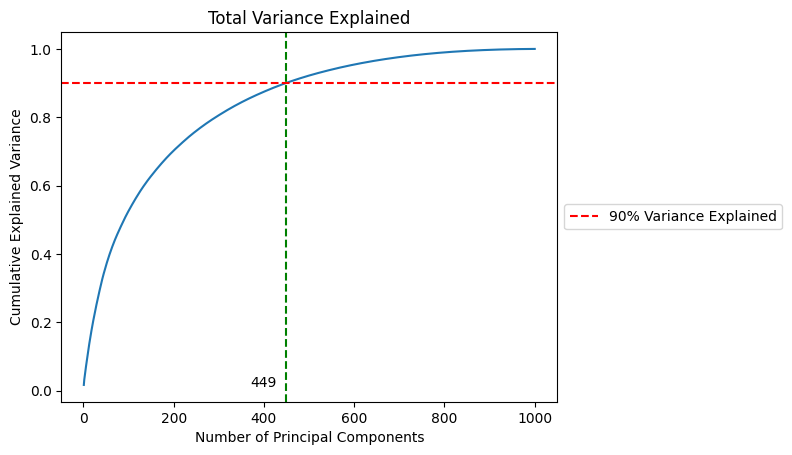

In [414]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 90%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.9)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx - 50, 0.01, f'{idx + 1}', ha='center')

plt.show()

START OF KNN

In [415]:
n_comp = 400
pca = PCA(n_components=n_comp)
df_tfidf_pca = pca.fit_transform(df_tfidf_reduced)

df_filtered_pca = pd.DataFrame(df_tfidf_pca, columns=[f'PC{i}' for i in range(1, n_comp+1)])

df_filtered_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,-0.000662,-0.000295,-0.000312,-0.000381,-0.000249,-0.000319,-0.000182,-0.000191,-0.000423,-0.000256,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
1,-0.000662,-0.000295,-0.000312,-0.000381,-0.000249,-0.000319,-0.000182,-0.000191,-0.000423,-0.000256,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
2,-0.000728,-0.000327,-0.000363,-0.000448,-0.000295,-0.000378,-0.000218,-0.000232,-0.000496,-0.000306,...,0.002750,-0.002012,0.004145,-0.002496,-0.001943,0.001148,-0.000600,0.003417,0.004938,0.002544
3,-0.000727,-0.000327,-0.000360,-0.000443,-0.000293,-0.000362,-0.000215,-0.000227,-0.000497,-0.000303,...,0.007393,-0.001223,0.001736,-0.006717,-0.004324,-0.003052,-0.003222,0.003143,0.005034,-0.005455
4,-0.000685,-0.000306,-0.000328,-0.000403,-0.000264,-0.000339,-0.000194,-0.000201,-0.000449,-0.000272,...,-0.002196,0.004474,-0.002285,-0.002621,-0.003192,0.000667,0.001291,-0.003629,0.001188,0.003620


In [416]:
#############
# new data frame containing all the numerical features
############
new_df = pd.concat([df.reset_index(drop=True), df_filtered_pca.reset_index(drop=True)], axis = 1)
new_df = new_df.reset_index(drop=True)
new_df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:SENSATION:TASTE,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:AFFECTION,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,"[i'v, got, a, newfound, fangl, fandango, tango...",14,83,\nI've got a new-found fangled fandango tango ...,angle,0,0.045455,0.034091,0.034091,0.022727,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
1,"[you'v, been, away, for, such, a, long, long, ...",15,140,"\nYou've been away for such a long, long time\...",50 pieces,0,0.013699,0.000000,0.020548,0.000000,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
2,"[overprescrib, under, the, mister, we, had, su...",48,260,\nOverprescribed\nUnder the mister\nWe had sur...,a nervous tic motion of the head to the left,0,0.000000,0.000000,0.036364,0.000000,...,0.002750,-0.002012,0.004145,-0.002496,-0.001943,0.001148,-0.000600,0.003417,0.004938,0.002544
3,"[sinc, i, first, saw, him, i, think, myself, b...",21,164,"\nSince I first saw him, I think myself blind....",a woman's life and love,0,0.018182,0.006061,0.006061,0.012121,...,0.007393,-0.001223,0.001736,-0.006717,-0.004324,-0.003052,-0.003222,0.003143,0.005034,-0.005455
4,"[now, if, you, think, i'm, wast, your, time, a...",46,258,\nNow if you think I'm wasting your time again...,action adventure,0,0.010417,0.000000,0.006944,0.000000,...,-0.002196,0.004474,-0.002285,-0.002621,-0.003192,0.000667,0.001291,-0.003629,0.001188,0.003620


In [417]:
from sklearn.preprocessing import StandardScaler

numerical_df = new_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
numerical_df.head()

,Nb_Lines,Nb_Words,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:SENSATION:TASTE,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:AFFECTION,RID_SECONDARY:TEMPORAL:REFERENCES,RID_EMOTIONS:AGGRESSION,RID_PRIMARY:SENSATION:SOFT,RID_SECONDARY:ABSTRACTION,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,14,83,0.045455,0.034091,0.034091,0.022727,0.022727,0.011364,0.011364,0.011364,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
1,15,140,0.013699,0.000000,0.020548,0.000000,0.034247,0.013699,0.000000,0.027397,...,-0.000193,0.000013,0.000016,-0.000096,-0.000125,0.000171,0.000015,-0.000027,0.000004,-0.000209
2,48,260,0.000000,0.000000,0.036364,0.000000,0.014545,0.000000,0.000000,0.018182,...,0.002750,-0.002012,0.004145,-0.002496,-0.001943,0.001148,-0.000600,0.003417,0.004938,0.002544
3,21,164,0.018182,0.006061,0.006061,0.012121,0.012121,0.012121,0.006061,0.012121,...,0.007393,-0.001223,0.001736,-0.006717,-0.004324,-0.003052,-0.003222,0.003143,0.005034,-0.005455
4,46,258,0.010417,0.000000,0.006944,0.000000,0.072917,0.000000,0.000000,0.024306,...,-0.002196,0.004474,-0.002285,-0.002621,-0.003192,0.000667,0.001291,-0.003629,0.001188,0.003620


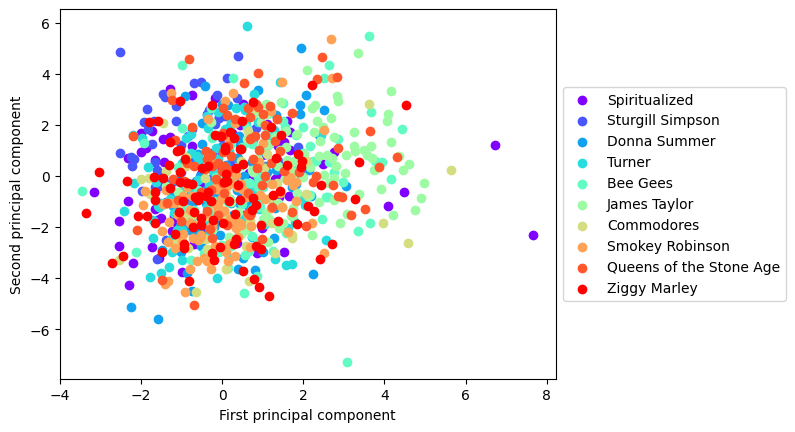

In [418]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

artist_labels = [arts_dict_op[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors
for label, art, color in zip(sample, artist_labels, colors):
    mask = (y_filtered == label)
    scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

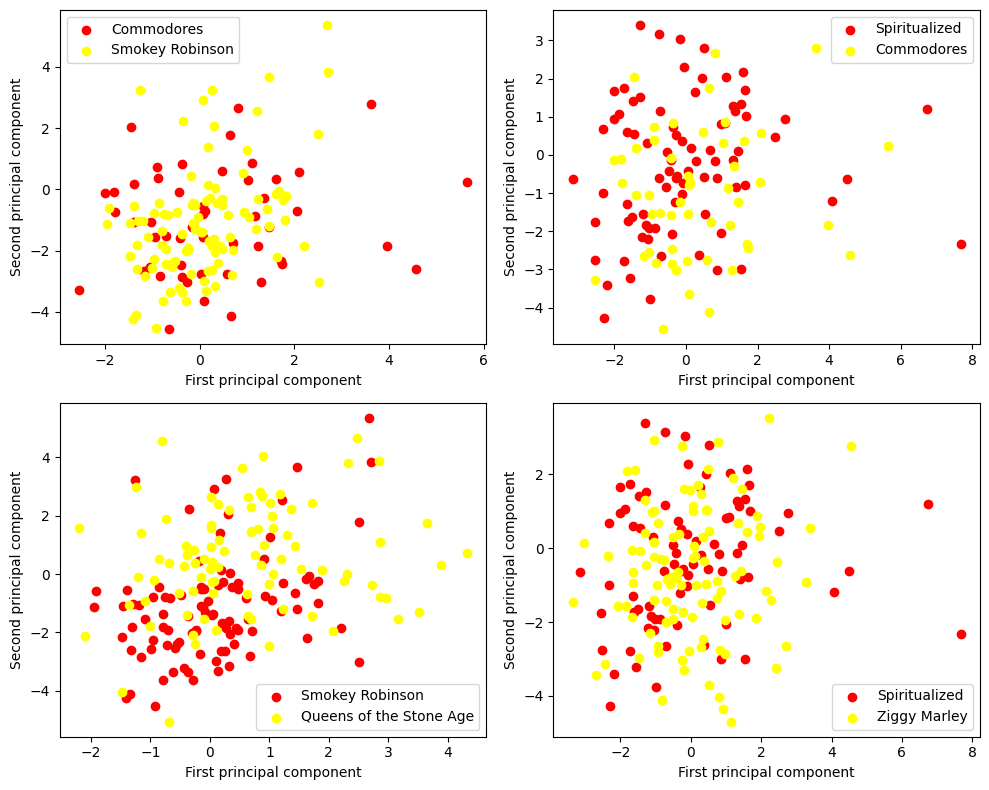

In [422]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

import itertools
import random

# Define the sampled indices and artist labels for each graph
combinations = list(itertools.combinations(sample, 2))
random.shuffle(combinations)
sampled_indices = combinations[:4]
artist_labels_list = [[arts_dict_op[i] for i in indices] for indices in sampled_indices]

# Assign red and yellow to the first and second labels, respectively
colors_list = ['red', 'yellow']

# Plot the graphs using a loop
plt.figure(figsize=(10, 8))

for i, indices in enumerate(sampled_indices):
    plt.subplot(2, 2, i + 1)
    for j, label in enumerate(indices):
        mask = (y_filtered == label)
        color = colors_list[j % 2]  # Alternate between red and yellow
        scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=color, label=artist_labels_list[i][j])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()

plt.tight_layout()
plt.show()

# GET THE TESTING DATA

In [425]:
artists = new_df['Artist'].unique()

train_df, test_df = train_test_split(new_df, test_size=0.15, stratify=new_df['Artist'])

print(f'Training size : {train_df.shape[0]}')
print(f'Testing size : {test_df.shape[0]}')

Training size : 3237
Testing size : 572


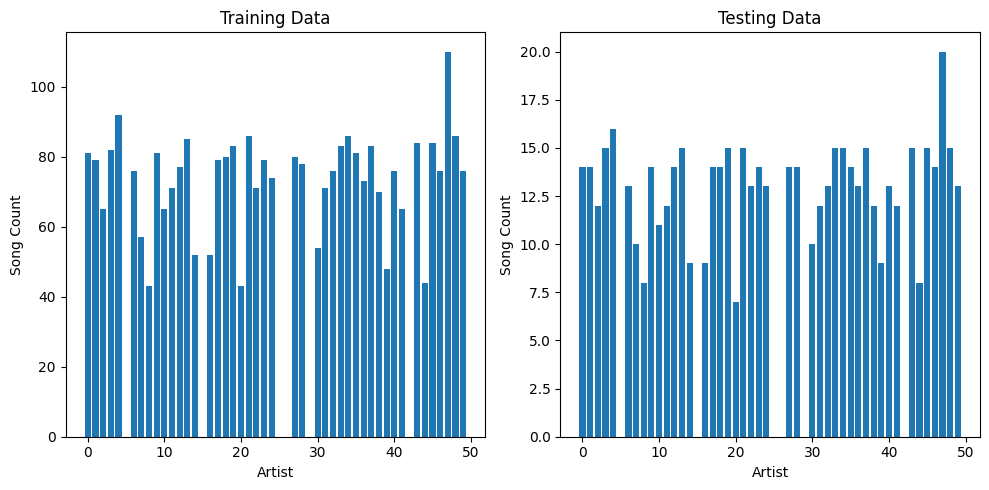

In [426]:
# Get the count of songs per artist in the training dataset
train_artist_counts = train_df['Artist'].value_counts()

# Get the count of songs per artist in the testing dataset
test_artist_counts = test_df['Artist'].value_counts()

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the song distribution per artist in the training dataset
axes[0].bar(train_artist_counts.index, train_artist_counts.values)
axes[0].set_title('Training Data')
axes[0].set_xlabel('Artist')
axes[0].set_ylabel('Song Count')

# Plot the song distribution per artist in the testing dataset
axes[1].bar(test_artist_counts.index, test_artist_counts.values)
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Artist')
axes[1].set_ylabel('Song Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [427]:
scaler = StandardScaler()

x_train = train_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
x_train = scaler.fit_transform(x_train)
y_train = train_df['Artist']

x_test = test_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
x_test = scaler.fit_transform(x_test)
y_test = test_df['Artist'].to_numpy()

# KNN STARTS

In [153]:
def learn_knn(**kwargs):
    
    model = neighbors.KNeighborsClassifier(**kwargs)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    return acc

In [155]:
def run_knn():
    w_accu=[]
    nw_accu=[]
    l1_nw_accu=[]
    l1_w_accu=[]
    max_nei = 50
    big = (0,0,0)

    for i in range(1,max_nei):

        w_accu.append(learn_knn(n_neighbors=i, weights='distance'))
        nw_accu.append(learn_knn(n_neighbors=i))
        l1_w_accu.append(learn_knn(n_neighbors=i, weights='distance', p=1))
        l1_nw_accu.append(learn_knn(n_neighbors=i, p=1))

        if w_accu[-1] > big[0]:
            big = (w_accu[-1], i, 0)

        if nw_accu[-1] > big[0]:
            big = (nw_accu[-1], i, 1)

        if l1_w_accu[-1] > big[0]:
            big = (l1_w_accu[-1], i, 2)

        if l1_nw_accu[-1] > big[0]:
            big = (l1_nw_accu[-1], i, 3)

    best_acc = big[0]
    best_nei = big[1]
    best_param = big[2]

    if best_param == 0:
        best_param = "weighted"
    elif best_param == 1:
        best_param = "not weighted"
    elif best_param == 2:
        best_param = "weighted, L1 distance"
    elif best_param == 3:
        best_param = "not weighted, L1 distance"

    print(f'Best accuracy: {best_acc}\nWith: {best_nei} neighbors, parameters: {best_param}')

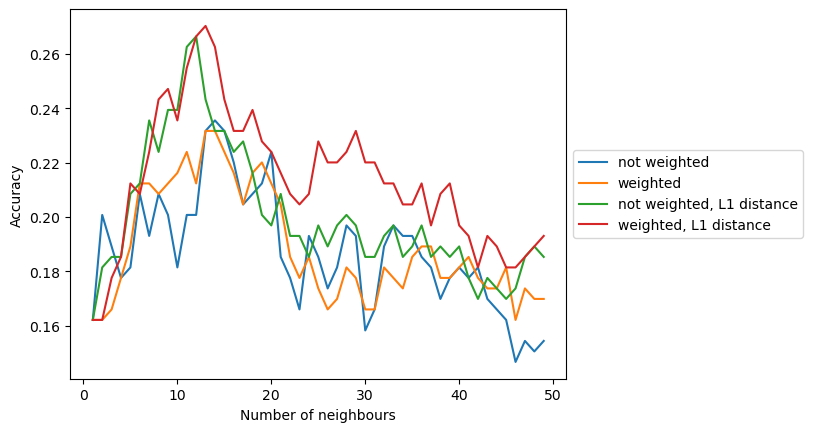

In [ ]:
def plot_knn():
    # Create a list of x-values for the parameter variations (e.g., parameter values from 1 to 30)
    x_values = list(range(1, max_nei))

    # Plot the accuracies
    plt.plot(x_values, nw_accu, marker='', label = 'not weighted')
    plt.plot(x_values, w_accu, marker = '', label = 'weighted')
    plt.plot(x_values, l1_nw_accu, marker='', label = 'not weighted, L1 distance')
    plt.plot(x_values, l1_w_accu, marker = '', label = 'weighted, L1 distance')

    # Add labels and title to the plot
    plt.xlabel('Number of neighbours')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

In [ ]:
def test_knn():
    model = neighbors.KNeighborsClassifier(n_neighbors=best_nei, weights= 'distance', p=1)
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, cv=5)
    print("Accuracy scores:", scores)

Accuracy scores: [0.22222222 0.21256039 0.20772947 0.18357488 0.20289855]


In [ ]:
#y_pred = model.predict(x_test)
#accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
#print(accuracy)

0.2702702702702703


In [156]:
def confusion_matrix(y_test, y_pred):
    
     
    y_test_labels = [arts_dict_op[y] for y in y_test]
    y_pred_labels = [arts_dict_op[y] for y in y_pred]
    
    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    
    #index_labels = list(map(lambda artist: 'actual ' + artist, artists))
    index_labels = list(map(lambda artist: artist, arts_dict_op.keys()))

    #column_labels = list(map(lambda artist: 'predicted ' + artist, artists))
    column_labels = list(map(lambda artist: artist, arts_dict_op.keys()))

    df = pd.DataFrame(data=confusion_matrix, index=index_labels, columns=column_labels)
    
    
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
   
    return df


# LOGISTIC REGRESSION STARTS

In [ ]:
df2 = df.drop(df.columns[[0, 3]], axis=1)
Pcarray = df_filtered_pca.to_numpy()
df2.reset_index(drop=True, inplace=True)
df2['PCA'] = pd.Series(Pcarray.tolist())
df2.shape
df2

In [ ]:
fts = df2.columns
fts

In [ ]:
def mean_of_arrays(matrix):
    mean_values = np.mean(matrix, axis=0)
    return mean_values.tolist()

In [ ]:
def artist_df(artist):
    """
    takes the aritst number and the training dataframe
    returns the mean and std devaition for all somgs of that artist in that dataframe
    """
    art_data = df2[df2['Artist'] == artist]
    arrays = art_data['PCA'].values
    # Convert the arrays into a matrix
    matrix = np.stack(arrays)
    mean = np.array(mean_of_arrays(matrix))
    # Calculate the average features for artist number 4
    average_features_artist = art_data.mean(numeric_only=True)
    # Calculate the standard deviation of features for artist number 4
    std_features_artist = art_data.std(numeric_only=True)
    k= ((pd.DataFrame({'Average': average_features_artist, 'Standard Deviation': std_features_artist})).transpose()).drop("Artist", axis=1)
    return k,mean


In [ ]:
def std_rows(df):
    """
    takes a dataframe with first 2 rows belonging to artist and then the songs. 
    Returns the dataframe to be trained for that artist
    """
    art_pca =  df.iloc[0, -1]
    for i in range(2, len(df)):
        df.iloc[i, -1] = cosine_angle(art_pca, df.iloc[i, -1] )
    first_row = df.iloc[0, :-1]
    s_row = df.iloc[1, :-1]
    df.iloc[2:,:-1] = (first_row - df.iloc[2:,:-1])/s_row
    df = df.iloc[2:].reset_index(drop=True)
    return df

In [ ]:
def cosine_angle(vector1, vector2):
    """
    Similarity between 2 vectors between 0 and 1. To be used for PCAd TFIDF components.
    """
    dot_prod = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    cosine = dot_prod / (mag1 * mag2)
    theta = np.arccos(cosine)
    return theta

In [ ]:
n_art = len(artists)
pos_w = (n_art-1)/n_art
neg_w = 1/n_art

In [ ]:
y = df2['Artist']
X = df2.drop('Artist', axis=1)
print(X.shape)
y.shape

In [ ]:
#### WIll make the dataframe of songs for any artist
def df_maker(artist, df):
    """ 
    INPUTS
    artist- aritst number, int
    df- dataframe with songs and their features
    output- dataframe with featurs of the song wrt the aritst
    """
    art_df, meanpca = artist_df(artist)
    art_df["PCA"] = [meanpca, None]
    comb_df = pd.concat([art_df, df])
    return (std_rows(comb_df))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
probs =[]
coeffs=[]
for i in range(0,15):
    #X2  = pd.concat([df_maker(i,X_train), X_train.iloc[:, :-1]], axis =1)
    X2 = df_maker(i,X_train)
    print(X2.columns[X2.isnull().any()])
    X2 = pd.concat([X2.reset_index(drop=True), X_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
    #print(X2.isnull().any().any())
    X3 = pd.concat([df_maker(i,X_test).reset_index(drop=True), X_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
    y2 = y_train.apply(lambda x: 1 if x == i else 0)
    # Split the data into training and testing sets
    logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
    logreg.fit(X2, y2)
    coefficients = logreg.coef_
    coeffs.append(coefficients[0])
    probs.append(logreg.predict_proba(X3)[:, 1])
coeffs = np.vstack(coeffs)
coeffs= np.mean(coeffs, axis=0)
probs = np.array(probs)
answers = np.argmax(probs, axis=0)
answers

In [ ]:
#### s=0
y_test = np.array(y_test)
for i in range(0,len(answers)):
    if(answers[i] == y_test[i]):
        s+=1
s/len(answers)

In [ ]:
coeffs = np.absolute(coeffs)
coeffs = coeffs/np.linalg.norm(coeffs)

In [ ]:
fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
fts2+=fts3
print(len(fts2))
print(len(coeffs))
data = {'feature': fts2, 'coefficient': coeffs}
feature_importance_df = pd.DataFrame(data)
fig = px.bar(feature_importance_df.sort_values('coefficient'), x='feature', y='coefficient')
fig.show()